# Import Libraries

First, we need to import matplotlib libraries as well as numpy library.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

# Data loading

Then we assign the direction of training and testing data.

In [2]:
rel_train = 'images/Train/'
rel_test = 'images/Test/'
TRAIN_IMG_FOLDER = os.path.abspath(rel_train)
TEST_IMG_FOLDER = os.path.abspath(rel_test)

print(TRAIN_IMG_FOLDER)
print(TEST_IMG_FOLDER)

train_set_files = os.listdir(TRAIN_IMG_FOLDER)
test_set_files = os.listdir(TEST_IMG_FOLDER)

width  = 128
height = 128

/Users/yanghaitao/Learn/Github/lbp/PCA-Based-Face-Recognition/images/Train
/Users/yanghaitao/Learn/Github/lbp/PCA-Based-Face-Recognition/images/Test


Check:  All data from 'train' is included in 'test'?

In [3]:
train_id_file = set([f.split('_')[0] for f in train_set_files])
test_id_file = set([f.split('_')[0] for f in train_set_files])
print(train_id_file <= test_id_file)

True


Train Images:


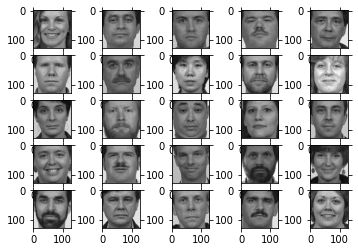

Test Images:


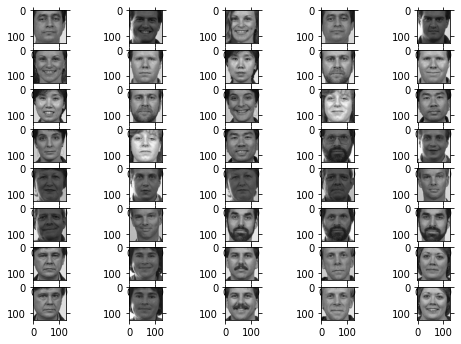

In [6]:
print('Train Images:')
train_image_names = os.listdir(TRAIN_IMG_FOLDER)
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)

for i in range(len(train_image_names)):
    img = plt.imread(TRAIN_IMG_FOLDER + "/" + train_image_names[i])
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(5,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

print('Test Images:')
test_image_names = os.listdir(TEST_IMG_FOLDER)#[i for i in dataset_dir if i not in train_image_names]
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)

for i in range(len(test_image_names)):
    img = imread(TEST_IMG_FOLDER + "/" + test_image_names[i])
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(8,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

# Calculate the mean face

The mean is just the sum of all of the pictures divided by the number of pictures. As a result, we will have an “average” face.

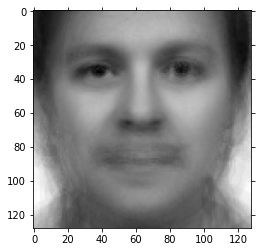

In [7]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

# Calculation of difference between training vector and mean vector

To normalize the training set, we just simply need to subtract for each picture in the training set the mean that was calculated in the previous step.

The reason why this is necessary is because we want to create a system that is able to represent any face. Therefore, we calculated the elements that all faces have in common (the mean). If we extract this average from the pictures, the features that distinguish each picture from the rest of the set are visible.

In [8]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)

# Display normalised faces

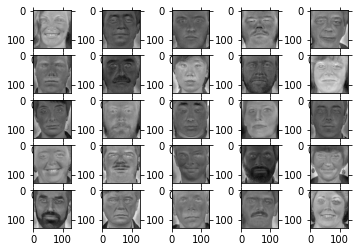

In [9]:
for i in range(len(train_image_names)):
    img = normalised_training_tensor[i].reshape(height,width)
    plt.subplot(5,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

# Converience Matrix

The covariance represents how two variables change together. After the previous step, we have a set of images that have different features, so now we want to see how these features for each individual picture change in relation to the rest of the pictures.

In [10]:
cov_matrix=np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix,25.0)
print('Covariance Matrix Shape:', cov_matrix.shape)
#print('Covariance matrix of X: \n%s' %cov_matrix)

Covariance Matrix Shape: (25, 25)


# Eigenvector of covariance

From the covariance we can extract the eigenvectors. Fortunately, there is a function that helps us in this step. There is plenty of information in the internet about eigenvectors but the general idea is that eigenvectors are the vectors of the covariance that describe the direction of the data.

In [11]:
#eigenvalues and eigenvectors
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
print('eigenvalues.shape: {} eigenvectors.shape: {}'.format(eigenvalues.shape, eigenvectors.shape))

eigenvalues.shape: (25,) eigenvectors.shape: (25, 25)


In [12]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

sorted_ind = sorted(range(eigenvalues.shape[0]), key=lambda k: eigenvalues[k], reverse=True)

eigvalues_sort = eigenvalues[sorted_ind]
eigvectors_sort = eigenvectors[sorted_ind]
train_set_files_sort = np.array(train_set_files)[sorted_ind]

# Find cumulative variance of each principle component

Cumulative proportion of variance explained vector: 
[0.28481989 0.41576165 0.49714907 0.55777059 0.60785024 0.65427472
 0.69489721 0.73168527 0.7641529  0.7916646  0.81546473 0.83669985
 0.85752859 0.87642433 0.89418977 0.91069532 0.92659352 0.94017913
 0.95309028 0.96500642 0.97612862 0.98491526 0.99275274 1.
 1.        ]


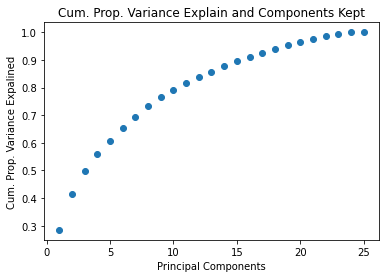

In [13]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

# Choose the necessary of principal components:

In [14]:
reduced_data = np.array(eigvectors_sort[:25]).transpose()
reduced_data.shape

(25, 25)

In [15]:
print(training_tensor.transpose().shape, reduced_data.shape)

(16384, 25) (25, 25)


# Calculate eigenfaces

Each eigenvector is multiplied by the whole normalized training set matrix and as a result, we will have the same amount of eigenfaces as images in our training set.

In [16]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()
proj_data.shape

(25, 16384)

# Plot eigen faces

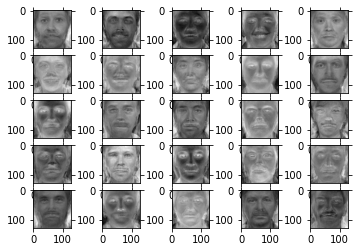

In [17]:
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height,width)
    plt.subplot(5,5,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

# Finding weights for each traning image

Each normalized face in the training set multiplies each eigenface. Consequently, there will be N set of weights with M elements (N = amount of pictures in the training set, M = number of eigenfaces).

In [18]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
print(w.shape)

(25, 25)


# Reconizing all test images

In [20]:
def recogniser(test_image_names, train_image_names,proj_data,w, t0=2e8, prn=False):

    count        = 0
    num_images   = 0
    correct_pred = 0
    
    result = []
    wts = []
    
    #False match rate (FMR)
    FMR_count = 0
    
    #False non-match rate (FNMR)
    FNMR_count = 0
     

    test_image_names2 = sorted(test_image_names)

    for img in test_image_names2:

        unknown_face = plt.imread(TEST_IMG_FOLDER+'/'+img)
        num_images += 1
        
        unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
        normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

        w_unknown = np.dot(proj_data, normalised_uface_vector)
        diff  = w - w_unknown
        norms = np.linalg.norm(diff, axis=1)
        index = np.argmin(norms)
        
        wts.append([count, norms[index]])

        if prn: print('Input:'+'.'.join(img.split('.')[:2]), end='\t')
        count+=1
        
        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        if norms[index] < t0: # It's a face
            if match:
                if prn: print('Matched:' + train_image_names[index], end = '\t')
                correct_pred += 1
                result.append(1)
            else:
                if prn: print('F/Matched:'+train_image_names[index], end = '\t')
                result.append(0)
                FMR_count += 1
        else:
            if match:
                if prn: print('Unknown face!'+train_image_names[index], end = '\t')
                FNMR_count +=1
                
            else:
                pass
                correct_pred += 1



        if prn: print(norms[index], end=' ')
        if prn: print()
            
            
    
    FMR = FMR_count/num_images
    FNMR = FNMR_count/num_images
    
    
    print('Correct predictions: {}/{} = {} \t\t'.format(correct_pred, num_images, correct_pred/num_images), end=' ')
    print('FMR: {} \t'.format(FMR), end=' ')
    print('FNMR: {} \t'.format(FNMR))
    
    
    
    return wts, result, correct_pred, num_images, FMR, FNMR
    

wts, result, correct_pred, num_images, FMR, FNMR =recogniser(test_image_names, train_image_names,proj_data,w, t0=2e8, prn=True)

Input:00770_960530_fa.jpg	Matched:00770_960530_fa.jpg	0.0 
Input:00770_960530_fa_a.jpg	F/Matched:00744_941201_fa.jpg	40443667.46730253 
Input:00771_941205_fa.jpg	Matched:00771_941205_fa.jpg	0.0 
Input:00771_941205_fb.jpg	Matched:00771_941205_fa.jpg	12411902.370116895 
Input:00772_941201_fa.jpg	Matched:00772_941201_fa.jpg	0.0 
Input:00772_941201_fb.jpg	F/Matched:00763_941201_fa.jpg	21167349.767040662 
Input:00773_941201_fa.jpg	Matched:00773_941201_fa.jpg	0.0 
Input:00773_941201_fb.jpg	Matched:00773_941201_fa.jpg	21385298.893085238 
Input:00775_941205_fa.jpg	Matched:00775_941205_fa.jpg	0.0 
Input:00775_941205_fb.jpg	Matched:00775_941205_fa.jpg	9590985.449027367 
Input:00779_941205_fa.jpg	Matched:00779_941205_fa.jpg	0.0 
Input:00779_941205_fb.jpg	Matched:00779_941205_fa.jpg	38922068.407121666 
Input:00781_941205_fa.jpg	Matched:00781_941205_fa.jpg	0.0 
Input:00781_941205_fb.jpg	F/Matched:00804_941205_fa.jpg	14277462.66798471 
Input:00787_941205_fa.jpg	Matched:00787_941205_fa.jpg	0.0 
Input

# Visualisation result of prediction
with high error threshold: t0 = 2e8

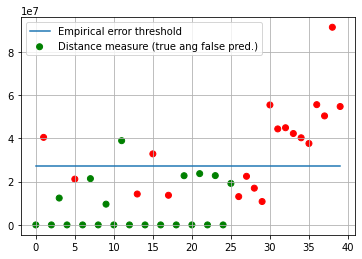

In [21]:
def rg(r):
    if r: return 'g'
    else: return 'r'
cl = [rg(r) for r in result]

x=[x[0] for x in wts]
y=[y[1] for y in wts]
plt.scatter(x,y, color=cl, label = 'Distance measure (true ang false pred.)')

x2=[x[0] for x in wts]
y2=[2.7e7 for y in wts]

plt.plot(x2,y2, label = 'Empirical error threshold')
plt.legend()
plt.grid()

plt.show()


In [22]:
CPR_list, t0_list, FMR_list, FNMR_list = [], [] , [] , []
for t0 in np.linspace(start=0, stop=1e8, num=20):
    print('{:e}'.format(t0), end=' ')
    wts, result, correct_pred, num_images, FMR, FNMR = recogniser(test_image_names, train_image_names,proj_data,w, t0)
    
    CPR_list.append(correct_pred/num_images) 
    t0_list.append(t0)
    FMR_list.append(FMR)
    FNMR_list.append(FNMR)

0.000000e+00 Correct predictions: 19/40 = 0.475 		 FMR: 0.0 	 FNMR: 0.525 	
5.263158e+06 Correct predictions: 32/40 = 0.8 		 FMR: 0.0 	 FNMR: 0.2 	
1.052632e+07 Correct predictions: 33/40 = 0.825 		 FMR: 0.0 	 FNMR: 0.175 	
1.578947e+07 Correct predictions: 30/40 = 0.75 		 FMR: 0.1 	 FNMR: 0.15 	
2.105263e+07 Correct predictions: 30/40 = 0.75 		 FMR: 0.125 	 FNMR: 0.125 	
2.631579e+07 Correct predictions: 32/40 = 0.8 		 FMR: 0.175 	 FNMR: 0.025 	
3.157895e+07 Correct predictions: 32/40 = 0.8 		 FMR: 0.175 	 FNMR: 0.025 	
3.684211e+07 Correct predictions: 31/40 = 0.775 		 FMR: 0.2 	 FNMR: 0.025 	
4.210526e+07 Correct predictions: 29/40 = 0.725 		 FMR: 0.275 	 FNMR: 0.0 	
4.736842e+07 Correct predictions: 26/40 = 0.65 		 FMR: 0.35 	 FNMR: 0.0 	
5.263158e+07 Correct predictions: 25/40 = 0.625 		 FMR: 0.375 	 FNMR: 0.0 	
5.789474e+07 Correct predictions: 22/40 = 0.55 		 FMR: 0.45 	 FNMR: 0.0 	
6.315789e+07 Correct predictions: 22/40 = 0.55 		 FMR: 0.45 	 FNMR: 0.0 	
6.842105e+07 Correct pr

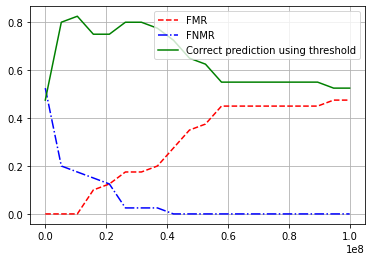

In [23]:
x1=t0_list
y1=FMR_list

x2=t0_list
y2=FNMR_list

x3=t0_list
y3=CPR_list

plt.plot(x1,y1, ls='--', color='r', label='FMR',)
plt.plot(x2,y2, ls='-.', color='b', label='FNMR')
plt.plot(x3,y3, color='g', label='Correct prediction using threshold')

plt.grid()
plt.legend()

# Visualization of prediction result on all test images

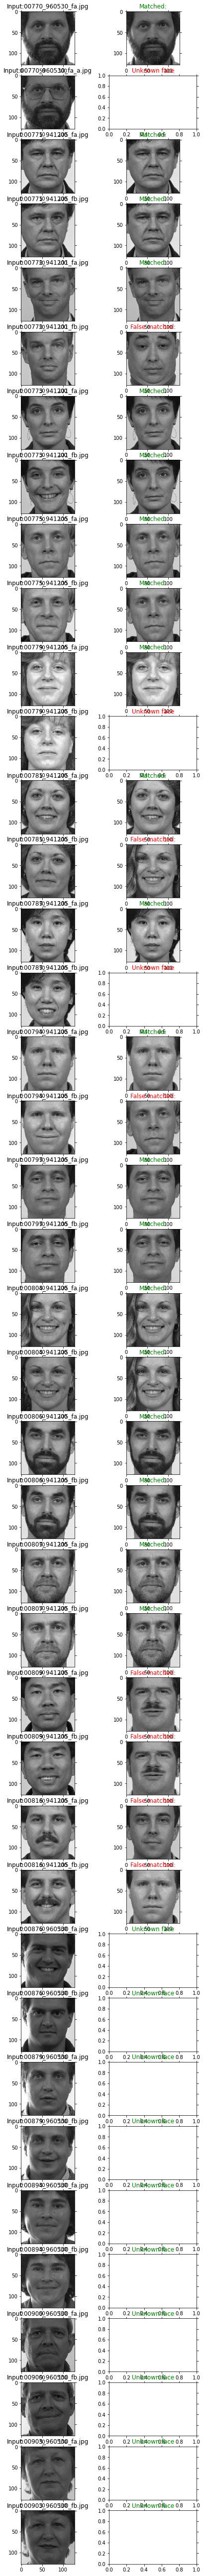

In [25]:
count        = 0
num_images   = 0
correct_pred = 0
def Visualization(img, train_image_names,proj_data,w, t0):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread(TEST_IMG_FOLDER+'/'+img)
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(40,2,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
   

    
    plt.subplot(40,2,1+count)
    if norms[index] < t0: # It's a face
            
        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        #if img.split('.')[0] == train_image_names[index].split('.')[0]:
        if match:
            #plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
            plt.title('Matched:', color='g')
            plt.imshow(imread(TRAIN_IMG_FOLDER+'/'+train_image_names[index]), cmap='gray')
                
            correct_pred += 1
        else:
            #plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
            plt.title('False matched:', color='r')
            plt.imshow(imread(TRAIN_IMG_FOLDER+'/'+train_image_names[index]), cmap='gray')
    else:
        #if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
        if img.split('_')[0] not in [i.split('_')[0] for i in train_image_names]:
            plt.title('Unknown face', color='g')
            correct_pred += 1
        else:
            plt.title('Unknown face', color='r')
                
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.subplots_adjust(right=1.2, top=2.5)
   
    count+=1

    
fig = plt.figure(figsize=(5, 30))

test_image_names2 = sorted(test_image_names)
for i in range(len(test_image_names2)):
    Visualization(test_image_names2[i], train_image_names,proj_data,w, t0=2.7e7)

plt.show()